Created by Michal Bukowski (michal.bukowski@tuta.io, m.bukowski@uj.edu.pl) under GPL-3.0 license as a part of the [dge-ontology](https://github.com/michalbukowski/dge-ontology) repository<br>
Department of Analytical Biochemistry, Biophysics and Biotechnology, Jagiellonian University, Krakow, Poland

---
# Extra examples of `dgeontology` library usage
This Jupyter notebook demonstrates an approach to ontology analysis (GSEA, gen set enrichment analysis) and visualisation performed for DGE (differential gene expression) results that were obtained using [Salmon](https://doi.org/10.1186/s13059-014-0550-8) and [DESeq2](https://doi.org/10.1038/nmeth.4197). However, the approach can be used for any kind of differential analysis (e.g. in proteomics). Execution of subsequent cells in many instances relies on the output of preceding cells, thus <u>cells should be executed in the order as presented in this notebook</u>.

<u>Notebook cell output has been saved in the original (repository) version of the notebook</u>. If rerun for the exemplary data, it should give the same results. All visualisations are saved to `output` directory as high-resolution PNG files.

This example uses input that contains metadata on _Staphylococcus aureus_ USA300 FPR3757 transcriptome and output from [rnaseq-pipeline-2](https://github.com/michalbukowski/rnaseq-pipeline-2) executed for two strains sampled in the logarithmic growth phase: a wild type (`wt`) vs. $\Delta$_saoC_ mutant (`mt`) (NCBI BioProject accession number PRJNA1017382).

It shows how to use the `dgeont_plot()` function from the `dgeontology` library in order to:
- perform GSEA (gen set enrichment analysis) at different FDR (false discovery rate) and fold change threshold values
- depict selected ontology labels in a custom order
- skip selected ontology labels
- filter out ontology labels based on the corresponding results count
- adjust fold change scale range in order to render mutually comparable pie charts

---
## Environment setup
As the first step, necessary imports and environment setup are performed.

In [1]:
# Import Pandas library for the input data handling.
import pandas as pd

# Import the dgeont_plot() function from the dgeontology library
# for rendering DGE/GSEA pie charts.
from dgeontology import dgeont_plot

# Configure the environments to make sure the way figures
# are displayed in the notebook is the same as they are saved.
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

---
## Loading the input data
The input data is read into Pandas DataFrames. The crucial aspect here is setting each DataFrame index to <u>a column that holds IDs of the analysed entities </u> (e.g. transcripts). For demonstration purposes, purely optionally, the content of the resulting DataFrames is inspected.

In [2]:
# Load DGE results for a complete population,
# i.e. even for those entities (genes, proteins)
# that could be present in the sample (bacterial transcriptome,
# proteome, etc.) but were not (e.g. non-transcribed genes).
# In this example two groups were compared:
# wt - wild type, mt - mutant.
# Importantly, the column that contains IDs of analysed
# entities is set to be the DataFrame index.
dge_us_df = pd.read_csv(
    'input/us_wt_mt_DGE.tsv',
    index_col = 'locus_tag',
    sep = '\t'
)
display(dge_us_df.info())
dge_us_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3347 entries, SAUSA300_RS14695 to SAUSA300_RS10235
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   baseMean        2666 non-null   float64
 1   log2FoldChange  2666 non-null   float64
 2   lfcSE           2666 non-null   float64
 3   pvalue          2666 non-null   float64
 4   padj            2666 non-null   float64
dtypes: float64(5)
memory usage: 156.9+ KB


None

,baseMean,log2FoldChange,lfcSE,pvalue,padj
locus_tag,,,,,
SAUSA300_RS14695,20.544586,-0.120664,0.381341,0.726461,0.853952
SAUSA300_RS14690,253.693766,-0.150871,0.168053,0.359385,0.573726
SAUSA300_RS14680,243.708504,-0.021730,0.181623,0.901613,0.946909
SAUSA300_RS14675,453.791421,0.146442,0.140981,0.290898,0.499056
SAUSA300_RS15675,54.560538,-0.634723,0.262479,0.011485,0.037431


In [3]:
# Load metadata for all entities (genes, transcripts, proteins, etc.).
# Importantly, the column that contains IDs of analysed
# entities is set to be the DataFrame index.
meta_us_df = pd.read_csv(
    'input/us.tsv',
    index_col = 'locus_tag',
    sep = '\t'
)
display(meta_us_df.info())
meta_us_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3474 entries, SAUSA300_RS00010 to srn_5130_Sau6728
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   type             3474 non-null   object
 1   pan_gene_symbol  1521 non-null   object
 2   product          3474 non-null   object
 3   vfdbont          137 non-null    object
 4   cog              1805 non-null   object
dtypes: object(5)
memory usage: 162.8+ KB


None

,type,pan_gene_symbol,product,vfdbont,cog
locus_tag,,,,,
SAUSA300_RS00010,CDS,dnaA,chromosomal replication initiator protein DnaA,NaN,"Replication, recombination and repair"
SAUSA300_RS00015,CDS,dnaN,DNA polymerase III subunit beta,NaN,"Replication, recombination and repair"
SAUSA300_RS00020,CDS,NaN,RNA-binding protein,NaN,"Translation, ribosomal structure and biogenesis"
SAUSA300_RS00025,CDS,recF,DNA replication and repair protein RecF,NaN,"Replication, recombination and repair"
SAUSA300_RS00030,CDS,gyrB,DNA gyrase subunit B,NaN,"Replication, recombination and repair"


---
## Plot 1
Render a plot as depicted in the `fig. 2` in the original DGE-ontology publication in SoftwareX (Elsevier) journal using the `dgeont_plot()` function. The function requires 7 obligatory arguments, default values for 7 optional ones are adjusted.

2 required positional arguments:
- `dge_df` &ndash; Pandas DataFrame containing DGE results. The DataFrame must be index with analysed entities IDs (e.g. transcript IDs).
- `meta_df` &ndash; Pandas DataFrame linking IDs to ontology labels. The DataFrame must also be index with analysed entities IDs.

5 required keyword arguments:
- `fold_col` &ndash; the name of the column in `dge_df` that contains fold change values, a string value.
- `pval_col` &ndash; the name of the column in `dge_df` that contains FDR values, a string value.
- `onts_col` &ndash; the name of the column in `meta_df` that contains ontology labels, a string value.
- `fold_th` &ndash; a minimal threshold value for `fold_col` (fold change) absolute values used for filtering the results `dge_df`, a float value.
- `fdr_th` &ndash; a maximal threshold value for `pval_col` (FDR) used for fitering the results in `dge_df`, a float value.

7 optional keyword arguments used in this example:
- `type_col` &ndash; the name of the column in `meta_df` that describes the sequence type, a string value. The column is solely used in respect to _ncRNA_ and _tRNA_ values. Importantly, when `type_col` is not None, any other ontology labels, if provided in the remaining columns, are ignored for rows described as _ncRNA_ and _tRNA_. Default value: `None` (do not use _ncRNA_ and _tRNA_ sequence types as ontology labels).
- `bont_col` &ndash; the column name that contains additional ontology data, a string value. The values of the column are treated as binary (true or false, whether the values are empty/NA or any non-empty value) and described with the label (`bnt_label`). If `bont_col` is not None, `bont_label` is merged with labels provided in `onts_col`. Default value: `None` (no binary ontology column is provided).
- `bont_label` &ndash; If `bont_col` is not None, `bont_label` <u>must be set</u> to a string value that will be treated as ontology label for any non-empty with respect to `bont_col` row. Default value: `None` (no binary ontology column is provided).
- `pie_r` &ndash; the radius of the pie chart scaffold circle, a float value. Default value: `0.30`.
- `scale` &ndash; general scale factor, a float value. Change to increase or decrease the relative wedge radial sizes, especially if inner parts pass through the middle of the chart. Default value: `0.03`.
- `xmin` &ndash; the lower limit value for the X axis, a float value. Default value: `-2.5`.
- `xmax` &ndash; the upper limit value for the X axis, a float value. Default value: `2.5`.

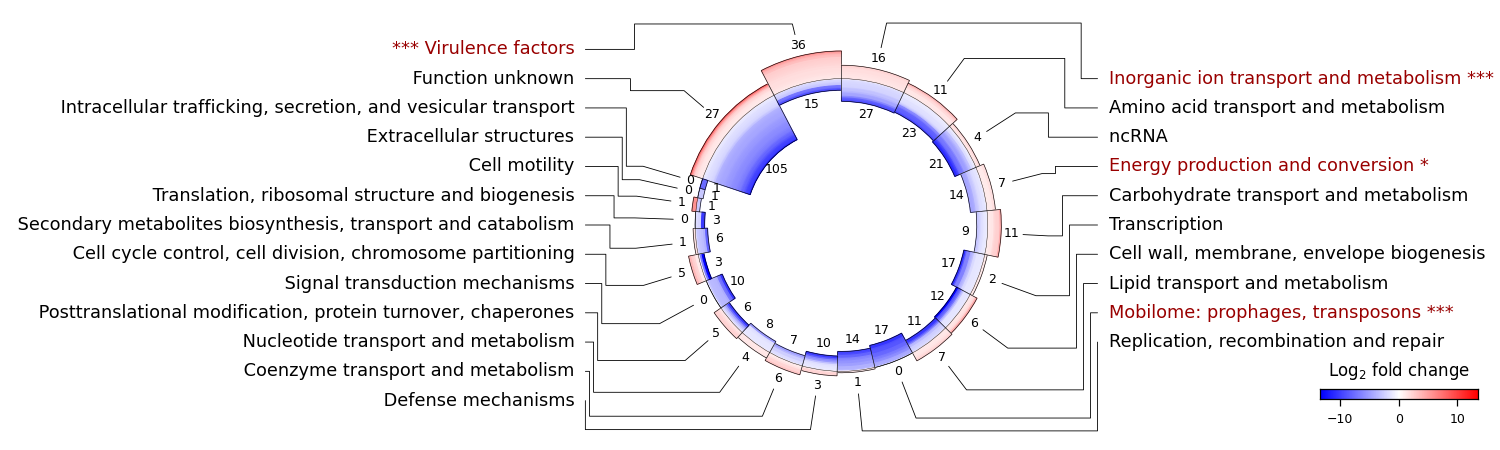

In [4]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_us_df, meta_us_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=1.00, fdr_th=0.01,
    type_col='type', bont_col='vfdbont', bont_label='Virulence factors', pie_r=0.4, scale=0.015, xmin=-2.3, xmax=1.8
)

---
## Processing of some of the output data returned by `dgeont_plot()` function
From the output DataFrame `ont_df` pick up ontology labels and sort them in a descending order primarily in respect to the number of results linked to them (`sample_size`). This is the default way the ontology labels are sorted in DGE-ontology pie charts as the one above. Convert the obtained Pandas Series into a list and inspect its content. The list will be used to recreate the order of ontology labels in the next chart.

In [5]:
sel_onts = ont_df.sort_values(['sample_cases', 'ont'], ascending=False).index.to_list()
sel_onts

['Function unknown',
 'Virulence factors',
 'Inorganic ion transport and metabolism',
 'Amino acid transport and metabolism',
 'ncRNA',
 'Energy production and conversion',
 'Carbohydrate transport and metabolism',
 'Transcription',
 'Lipid transport and metabolism',
 'Cell wall, membrane, envelope biogenesis',
 'Mobilome: prophages, transposons',
 'Replication, recombination and repair',
 'Defense mechanisms',
 'Coenzyme transport and metabolism',
 'Nucleotide transport and metabolism',
 'Posttranslational modification, protein turnover, chaperones',
 'Signal transduction mechanisms',
 'Cell cycle control, cell division, chromosome partitioning',
 'Secondary metabolites biosynthesis, transport and catabolism',
 'Translation, ribosomal structure and biogenesis',
 'Cell motility',
 'Intracellular trafficking, secretion, and vesicular transport',
 'Extracellular structures',
 'tRNA',
 'RNA processing and modification',
 'Intracellular trafficking and secretion',
 'Chromatin structure and

---
## Plot 2
Render a plot as depicted in the `fig. 3` in the original DGE-ontology publication in SoftwareX (Elsevier) journal. Next to the already modified optional arguments, use another one to set a custom order of ontology labels in the pie chart.

The optional keyword argument used additionally in this example that allows to modify the order of ontology labels in the pie chart:
- `sel_onts` &ndash; ontology labels that are to be depicted in the final pie chart, a list of string values. Default value: `None` (depict all ontology labels ordered in a descending order with respect to the number of results linked to them).

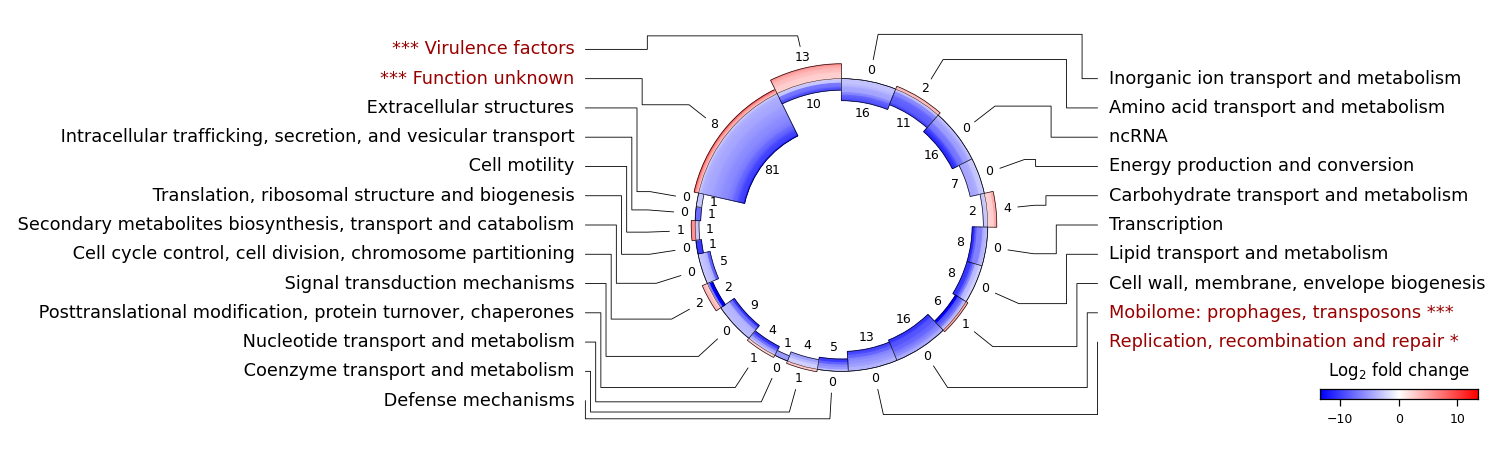

In [6]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_us_df, meta_us_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=2.32, fdr_th=0.01,
    type_col='type', bont_col='vfdbont', bont_label='Virulence factors', pie_r=0.4, scale=0.015, xmin=-2.3, xmax=1.8,
    sel_onts=sel_onts
)

---
## Plot 3
Render a plot similar to the Plot 2. Next to the already modified optional arguments, use another one that allows to skip selected ontology labels in the pie chart.

The optional keyword argument used additionally in this example that allows to skip selected ontology labels in the pie chart:
- `skip_onts` &ndash; ontology labels that are <u>not</u> to be depicted in the final pie chart, a list of string values. Default value: `None` (do not skip any ontology label).

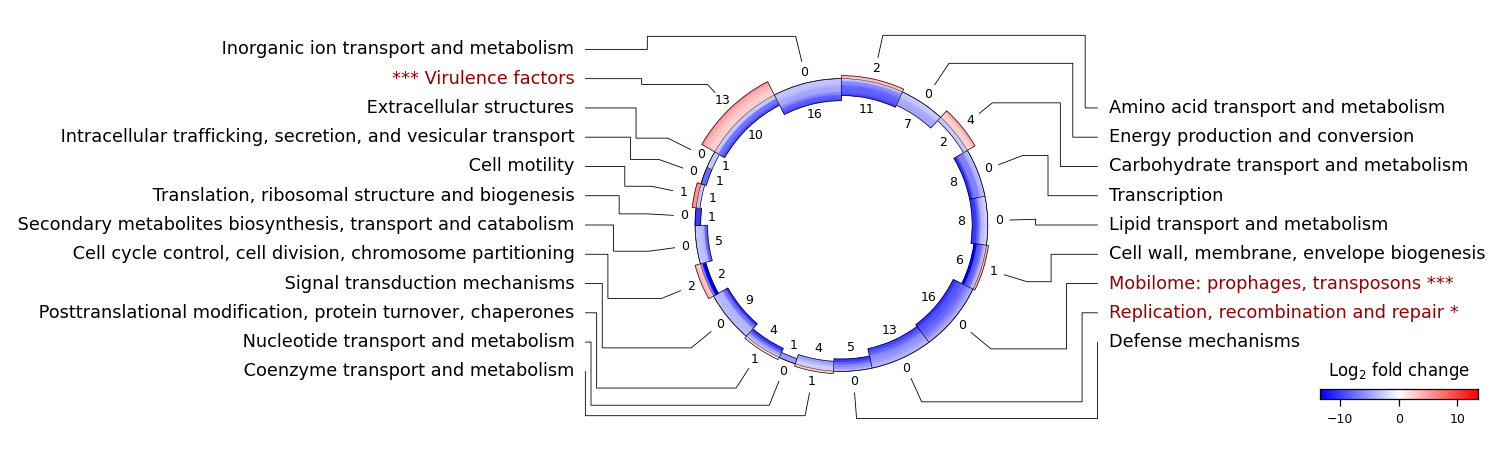

In [7]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_us_df, meta_us_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=2.32, fdr_th=0.01,
    type_col='type', bont_col='vfdbont', bont_label='Virulence factors', pie_r=0.4, scale=0.015, xmin=-2.3, xmax=1.8,
    sel_onts=sel_onts, skip_onts=['Function unknown', 'ncRNA']
)

---
## Plot 4
Render a plot as depicted in the `fig. 4` in the original DGE-ontology publication in SoftwareX (Elsevier) journal. Next to the already modified optional arguments, use another one that allows to skip ontology labels based on the minimal number of results linked to them.

The optional keyword argument used additionally in this example that allows to skip selected ontology labels based on the minimal number of results linked to them:
- `min_size` &ndash; a minimal count of results (rows from the filtered `dge_df`) assigned to an ontology label that are required for the label to be depicted in the final pie chart, an integer value. Default value: `0` (depict all ontology labels).

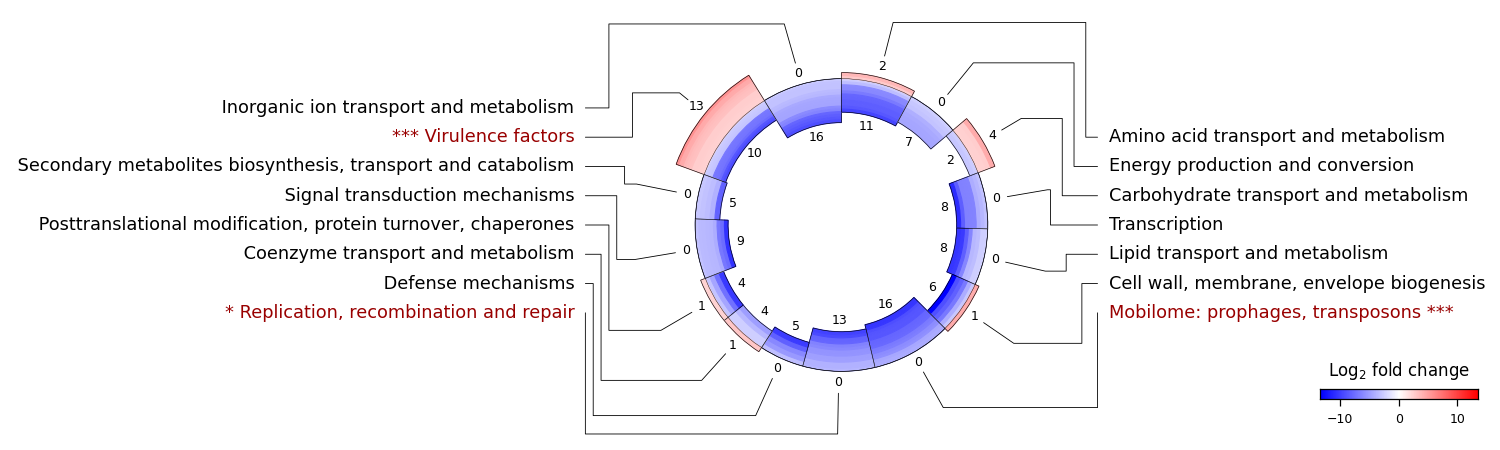

In [8]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_us_df, meta_us_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=2.32, fdr_th=0.01,
    type_col='type', bont_col='vfdbont', bont_label='Virulence factors', pie_r=0.4, scale=0.03, xmin=-2.3, xmax=1.8,
    sel_onts=sel_onts, skip_onts=['Function unknown', 'ncRNA'], min_size=5
)

## Processing of some of the output data returned by `dgeont_plot()` function
From the `filt_df` pick up the highest absolute fold change value (the default limit of the fold change scale used in the pie chart) in order to modify the scale of another one.

In [9]:
max_fold = filt_df['log2FoldChange'].abs().max()
max_fold

np.float64(13.423713008957)

---
## Plot 5
- Render a pie chart as depicted in the `fig. 5` in the original DGE-ontology publication in SoftwareX (Elsevier) journal. Next to the first 5 obligatory arguments, default values for 4 optional ones are adjusted.

4 optional keyword arguments used in this example:
- `bont_col` &ndash; the column name that contains additional ontology data, a string value. The values of the column are treated as binary (true or false, whether the values are empty/NA or any non-empty value) and described with the label (`bnt_label`). If `bont_col` is not None, `bont_label` is merged with labels provided in `onts_col`. Default value: `None` (no binary ontology column is provided).
- `bont_label` &ndash; If `bont_col` is not None, `bont_label` <u>must be set</u> to a string value that will be treated as ontology label for any non-empty with respect to `bont_col` row. Default value: `None` (no binary ontology column is provided).
- `xmin` &ndash; the lower limit value for the X axis, a float value. Default value: `-2.5`.
- `xmax` &ndash; the upper limit value for the X axis, a float value. Default value: `2.5`.

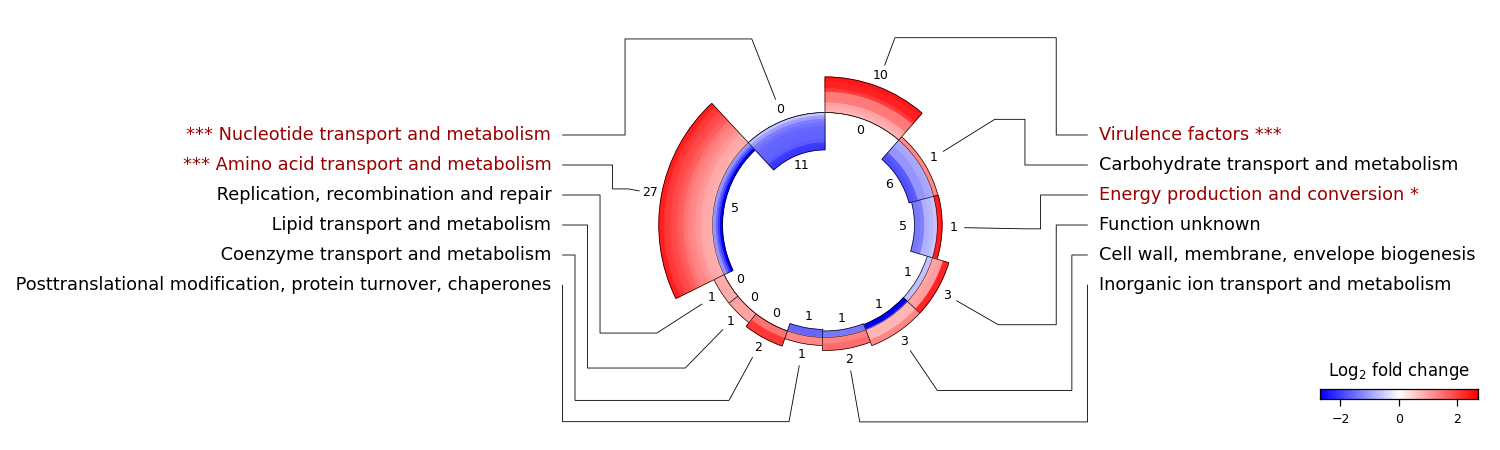

In [10]:
dge_rn_df = pd.read_csv(
    'input/mt51e_wt51e_DGE.tsv',
    index_col = 'locus_tag',
    sep = '\t'
)

meta_rn_df = pd.read_csv(
    'input/rn.tsv',
    index_col = 'locus_tag',
    sep = '\t'
)

fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_rn_df, meta_rn_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=0.58, fdr_th=0.05,
    bont_col='vfdbont', bont_label='Virulence factors', xmin=-2.2, xmax=1.8
)

---
## Plot 7
Render a plot as depicted in the `fig. 6` in the original DGE-ontology publication in SoftwareX (Elsevier) journal, which is a modified version of the Plot 6. Next to the already modified optional arguments, another 2 optional keyword arguments are modified in order to rotate the pie chart and adjust the fold change scale to make it comparable to the scale used in the Plot 4.

2 optional keyword arguments additionally used in this example:
- `angle_offset` &ndash; the angle offset for placing wedges on the scaffold circle in degrees (0.0 - 360.0), a float value. By default the third wedge/slice starts at 12:00 o'clock, top centre, which seems to be optimal for size-ordered slices. Default value: `0.0`.
- `max_fold` &ndash; the maximum fold value for the fold scale, a float value. If None, it is set automatically to the highest absolute fold value. Set it manually if you want to generate charts that depict results in a fixed scale. Default value: `None` (automatic scale, the highest absolute fold change value).

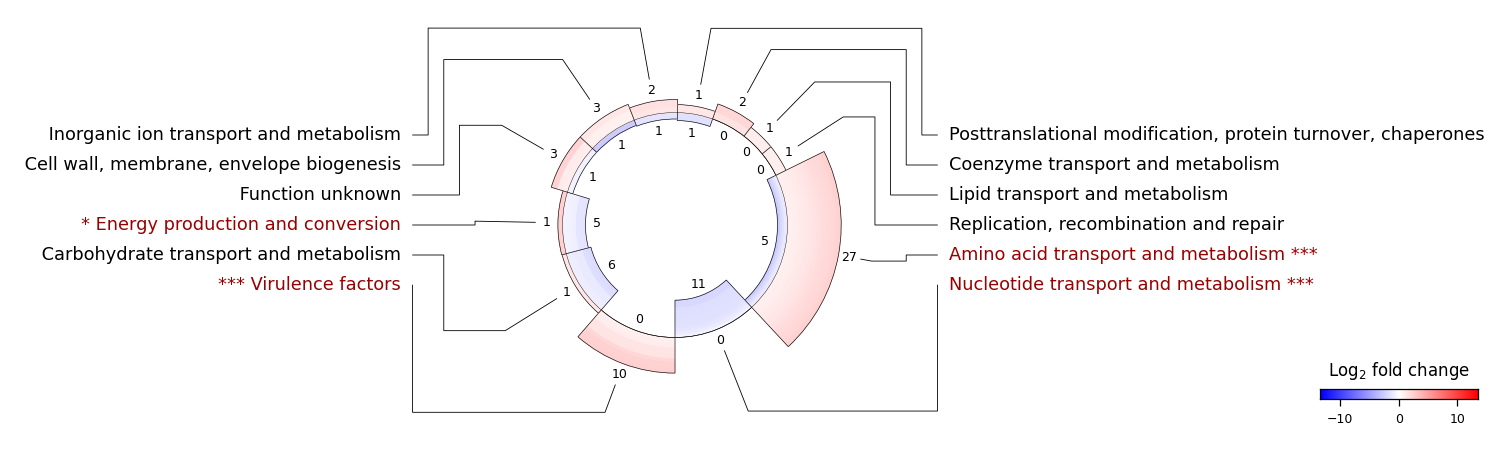

In [11]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_rn_df, meta_rn_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=0.58, fdr_th=0.05,
    bont_col='vfdbont', bont_label='Virulence factors', xmin=-1.8, xmax=2.2, angle_offset=180, max_fold=max_fold
)

---
## Plot 8
Render a plot similar to the Plot 5, however rotate it a bit and select manually the ontology labels that are to be depicted. Next to the already modified optional arguments, use another one that allows to select ontology labels that will be depicted in the pie chart.

The optional keyword argument used additionally in this example that allows to skip selected ontology labels based on the minimal number of results linked to them:
- `sel_onts` &ndash; ontology labels that are to be depicted in the final pie chart, a list of string values. Default value: `None` (depict all ontology labels).

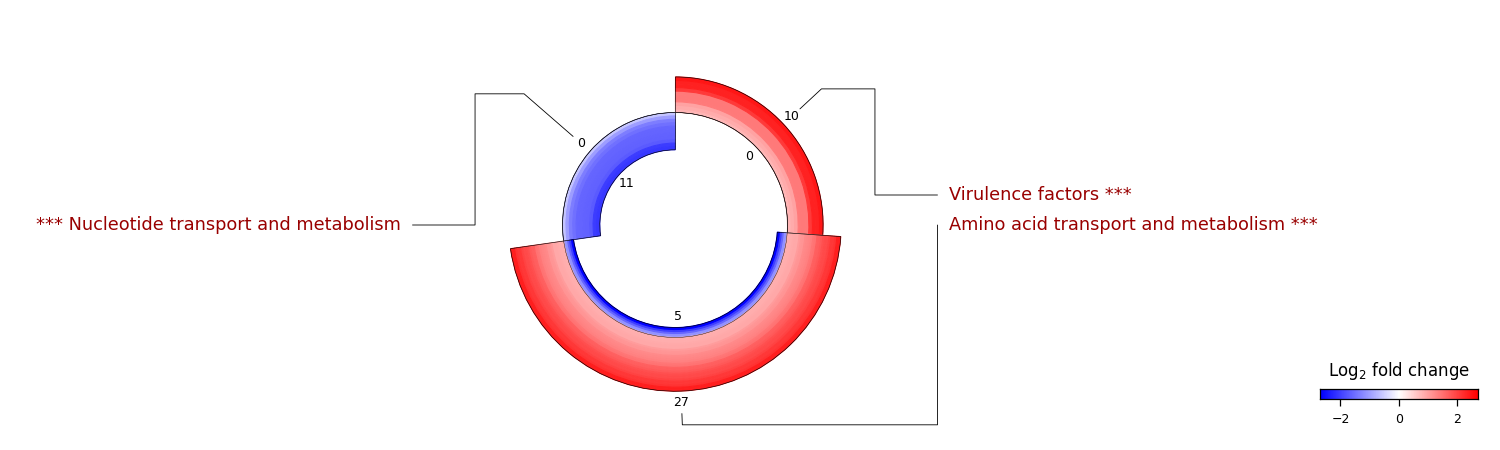

In [12]:
fin_df, filt_df, ont_df, fig, ax, ax_bar = dgeont_plot(
    dge_rn_df, meta_rn_df, fold_col='log2FoldChange', pval_col='padj', onts_col='cog', fold_th=0.58, fdr_th=0.05,
    bont_col='vfdbont', bont_label='Virulence factors', xmin=-1.8, xmax=2.2, angle_offset=94, sel_onts=[
        'Nucleotide transport and metabolism',
        'Virulence factors',
        'Amino acid transport and metabolism'
    ]
)